# Simulate with final network and generate car following trajectories, with speed ratio as an indicator of efficiency

In [1]:
CA = False
TTC_threshold = 4
#base_name = f'TTC{TTC_threshold}_2' 
#base_name = f'Speed_{TTC_threshold}' 
base_name = f'origin_{TTC_threshold}' 

In [2]:
import tensorflow as tf
import numpy as np
from car_following_origin import Maze
import scipy.io as sio
import pickle as pk
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tqdm import tqdm_notebook as tqdm
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

get_ipython().run_line_magic('matplotlib', 'inline')

# ## DDPG class

# np.random.seed(1)
# tf.set_random_seed(1)

#####################  hyper parameters  ####################
LR_A = 0.001  # learning rate for actor
LR_C = 0.001  # learning rate for critic
GAMMA = 0.9  # reward discount
REPLACE_ITER_A = 500
REPLACE_ITER_C = 300
MEMORY_CAPACITY = 20000  # 7000
BATCH_SIZE = 32


###############################  Actor  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound, ):
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()
        self.a_replace_counter, self.c_replace_counter = 0, 0

        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor'):
            self.a = self._build_a(self.S, scope='eval', trainable=True)
            a_ = self._build_a(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            q = self._build_c(self.S, self.a, scope='eval', trainable=True)
            q_ = self._build_c(self.S_, a_, scope='target', trainable=False)

        # networks parameters
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        q_target = self.R + GAMMA * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        td_error = tf.losses.mean_squared_error(labels=q_target, predictions=q)
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, var_list=self.ce_params)

        a_loss = - tf.reduce_mean(q)  # maximize the q  论文中是朝着Q最大化的方向更新参数 这里达到的是同样的效果
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        self.sess.run(tf.global_variables_initializer())

    def choose_action(self, s):
        return self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]

    def learn(self, replace):
        # hard replace parameters
        if self.a_replace_counter % REPLACE_ITER_A == 0 or replace:
            self.sess.run([tf.assign(t, e) for t, e in zip(self.at_params, self.ae_params)])
            # print('Actor target network replaced with eval net')
        if self.c_replace_counter % REPLACE_ITER_C == 0 or replace:
            self.sess.run([tf.assign(t, e) for t, e in zip(self.ct_params, self.ce_params)])
            # print('Critic target network replaced with eval network')
        self.a_replace_counter += 1;
        self.c_replace_counter += 1

        if self.pointer < MEMORY_CAPACITY:
            indices = np.random.choice(self.pointer, size=BATCH_SIZE)
        else:
            indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})  # {}place holder 处理输入

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def _build_a(self, s, scope, trainable):
        with tf.variable_scope(scope):
            net = tf.layers.dense(s, 30, activation=tf.nn.relu, name='l1', trainable=trainable)
            a = tf.layers.dense(net, self.a_dim, activation=tf.nn.tanh, name='a', trainable=trainable)
            return tf.multiply(a, self.a_bound, name='scaled_a')

    def _build_c(self, s, a, scope, trainable):
        with tf.variable_scope(scope):
            n_l1 = 30
            w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable=trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
            net = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            return tf.layers.dense(net, 1, trainable=trainable)  # Q(s,a)

    def savenet(self, file):
        saver = tf.train.Saver()
        saver.save(self.sess, 'save/' + file + '.ckpt')

    def restore(self, file):
        saver = tf.train.Saver()
        saver.restore(self.sess,  file + '.ckpt')

env = Maze(TTC_threshold)
s_dim = env.n_features
a_dim = env.n_actions
a_bound = env.action_Bound

# ## Load car following event data

# load training data
train = sio.loadmat('trainSet.mat')['calibrationData']
test = sio.loadmat('testSet.mat')['validationData']
trainNum = train.shape[0]
testNum = test.shape[0]
print('Number of training samples:', trainNum)
print('Number of validate samples:', testNum)

C:\anaconda\envs\velocity\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\anaconda\envs\velocity\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\anaconda\envs\velocity\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\anaconda\envs\velocity\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: P

Number of training samples: 938
Number of validate samples: 403


In [3]:
model_file = f'save/model_{base_name}'
ddpg = DDPG(a_dim, s_dim, a_bound)
ddpg.restore(model_file)

INFO:tensorflow:Restoring parameters from save/model_origin_10.1.ckpt


## Test on training data

In [4]:
# # train data
# total_episode = trainNum
# rolling_window = 100
# max_rolling_score = np.float('-inf')
# max_score = np.float('-inf')
# collision_train = 0
# episode_score = np.zeros(total_episode)  # average score of each car following event
# rolling_score = np.zeros(total_episode)
# cum_collision_num = np.zeros(total_episode)

# score_safe = np.zeros(total_episode)
# score_efficiency = np.zeros(total_episode)
# score_comfort = np.zeros(total_episode)

# sim_data = []
# reward_data = []

# for i in tqdm(range(total_episode)):
#     data = train[i, 0]
#     s = env.reset(data)
#     score = 0
#     score_s, score_e, score_c = 0, 0, 0  # part objective scores

#     while True:
#         # Add exploration noise
#         a = ddpg.choose_action(s)[0]
        
#         if CA:
#             # add collision avoidance guidance
#             state = env.s
#             space, svSpd, relSpd = state
#             lvSpd = svSpd + relSpd
#             RT = 1  # reaction time
#             SD = svSpd * RT + (svSpd ** 2 - lvSpd ** 2) / (2 * a_bound)

#             if space < SD:
#                 a = -a_bound

#         s_, r, done, r_info = env.step(a)
        
#         reward_data.append(r_info)

#         s = s_
#         score += r
#         score_s += r_info[3]
#         score_e += r_info[4]
#         score_c += r_info[5]

#         if done:
#             duration = data.shape[0]
#             score /= duration  # normalize with respect to car-following length
#             score_s /= duration
#             score_e /= duration
#             score_c /= duration

#             if env.isCollision == 1:
#                 collision_train += 1
#             break
        
#     # store traffic simulation data
#     sim_data.append(np.vstack((env.LVSpdData, env.SimSpeedData, env.SimSpaceData)).T)
    

#     # record episode results
#     episode_score[i] = score
#     score_safe[i] = score_s
#     score_efficiency[i] = score_e
#     score_comfort[i] = score_c
#     rolling_score[i] = np.mean(episode_score[max(0, i - rolling_window + 1):i + 1])
#     cum_collision_num[i] = collision_train

#     if max_score < score:
#         max_score = score

#     if rolling_score[i] > max_rolling_score:
#         max_rolling_score = rolling_score[i]

#     sys.stdout.write(
#         f'''\r Test with train data, Episode {i}, Score: {score:.2f}, Rolling score: {rolling_score[i]:.2f}, Max score: {max_score:.2f}, Max rolling score: {max_rolling_score:.2f}, collisions: {collision_train}   ''')
#     sys.stdout.flush()

# # save simulation data to npy file
# np.save(f'{base_name}_traj_train.npy', sim_data)
# reward_data = np.array(reward_data)
# np.save(f'{base_name}_rinfo_train.npy', reward_data)
# np.savez(f'{base_name}_score_train.npz', episode_score, score_safe, score_efficiency, score_comfort, rolling_score)

 Test with train data, Episode 937, Score: 0.54, Rolling score: 0.53, Max score: 0.65, Max rolling score: 0.59, collisions: 0    


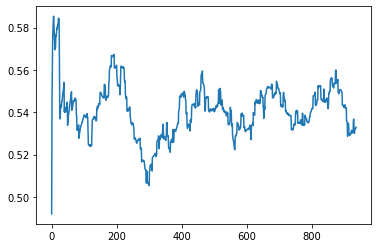

In [5]:
# plt.plot(rolling_score)

In [6]:
# # plot some car-following trjectories
# for i in range(20):
#     data = sim_data[i]
#     real_data = train[i,0]
    
#     plt.figure()
#     plt.plot(data[:,0], label = 'LV')
#     plt.plot(data[:,1], '--', label = 'RL SV')
#     plt.plot(real_data[:,1], label = 'human')
#     plt.legend()
#     plt.xlabel('Time')
#     plt.ylabel('Speed (m/s)')

In [7]:
# analyze reward data
# ttc_data = reward_data[:,0]
# mask = (ttc_data > 0) & (ttc_data < 10)
# plt.hist(ttc_data[mask]);

## Test on testing data

In [8]:
# test data
total_episode = testNum
rolling_window = 100
max_rolling_score = np.float('-inf')
max_score = np.float('-inf')
collision_train = 0
episode_score = np.zeros(total_episode)  # average score of each car following event
rolling_score = np.zeros(total_episode)
cum_collision_num = np.zeros(total_episode)

score_safe = np.zeros(total_episode)
score_efficiency = np.zeros(total_episode)
score_comfort = np.zeros(total_episode)

sim_data = []
reward_data = []

for i in tqdm(range(total_episode)):
    data = test[i, 0]
    s = env.reset(data)
    score = 0
    score_s, score_e, score_c = 0, 0, 0  # part objective scores

    while True:
        # Add exploration noise
        a = ddpg.choose_action(s)[0]
        
        if CA:
            # add collision avoidance guidance
            state = env.s
            space, svSpd, relSpd = state
            lvSpd = svSpd + relSpd
            RT = 1  # reaction time
            SD = svSpd * RT + (svSpd ** 2 - lvSpd ** 2) / (2 * a_bound)

            if space < SD:
                a = -a_bound

        s_, r, done, r_info = env.step(a)
        
        reward_data.append(r_info)

        s = s_
        score += r
        score_s += r_info[3]
        score_e += r_info[4]
        score_c += r_info[5]

        if done:
            duration = data.shape[0]
            score /= duration  # normalize with respect to car-following length
            score_s /= duration
            score_e /= duration
            score_c /= duration

            if env.isCollision == 1:
                collision_train += 1
            break
        
    # store traffic simulation data
    sim_data.append(np.vstack((env.LVSpdData, env.SimSpeedData, env.SimSpaceData)).T)
    

    # record episode results
    episode_score[i] = score
    score_safe[i] = score_s
    score_efficiency[i] = score_e
    score_comfort[i] = score_c
    rolling_score[i] = np.mean(episode_score[max(0, i - rolling_window + 1):i + 1])
    cum_collision_num[i] = collision_train

    if max_score < score:
        max_score = score

    if rolling_score[i] > max_rolling_score:
        max_rolling_score = rolling_score[i]

    sys.stdout.write(
        f'''\r Test with test data, Episode {i}, Score: {score:.2f}, Rolling score: {rolling_score[i]:.2f}, Max score: {max_score:.2f}, Max rolling score: {max_rolling_score:.2f}, collisions: {collision_train}   ''')
    sys.stdout.flush()

#save simulation data to npy file
np.save(f'{base_name}_traj_test.npy', sim_data)
reward_data = np.array(reward_data)
np.save(f'{base_name}_rinfo_test.npy', reward_data)
np.savez(f'{base_name}_score_test.npz', episode_score, score_safe, score_efficiency, score_comfort, rolling_score)

 Test with test data, Episode 402, Score: 0.64, Rolling score: 0.57, Max score: 0.64, Max rolling score: 0.60, collisions: 0    


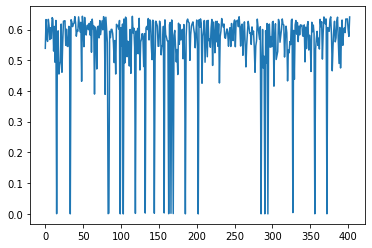

In [9]:
plt.plot(episode_score)

In [10]:
np.mean(episode_score)

0.5509346847805594

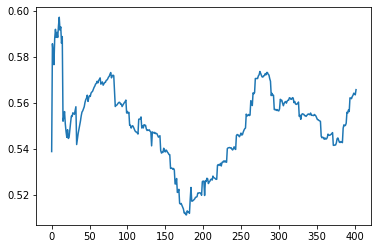

In [11]:
plt.plot(rolling_score)

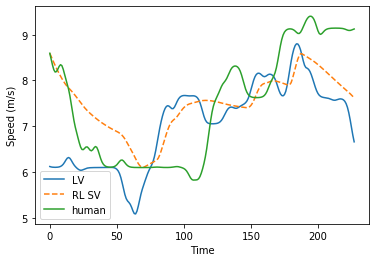

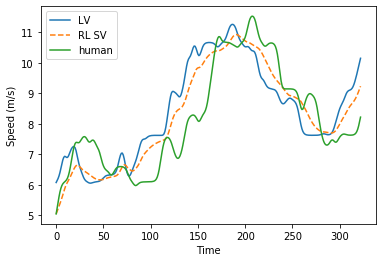

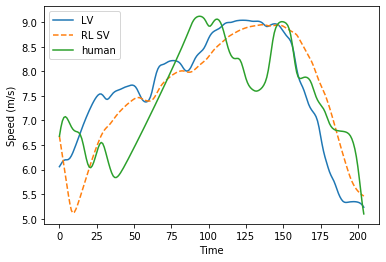

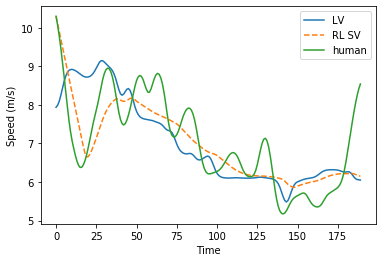

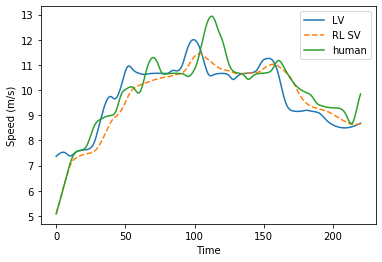

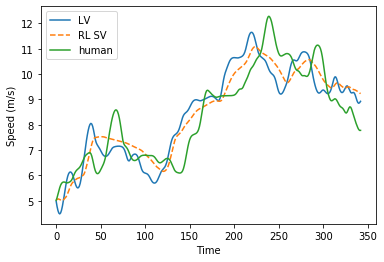

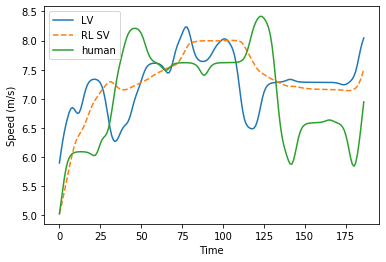

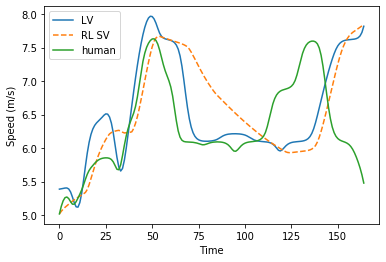

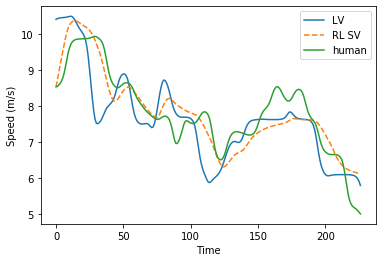

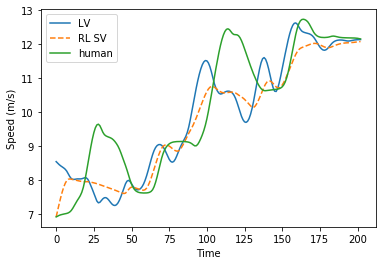

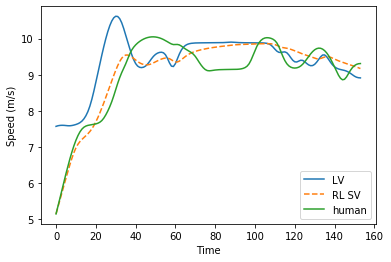

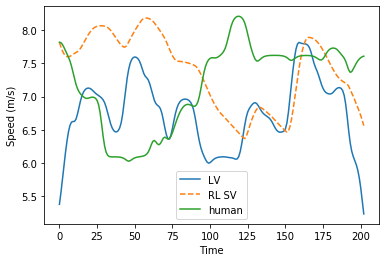

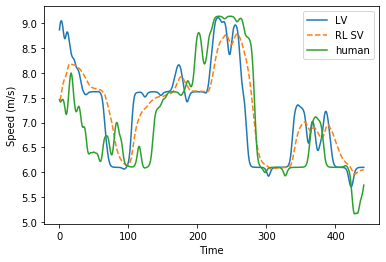

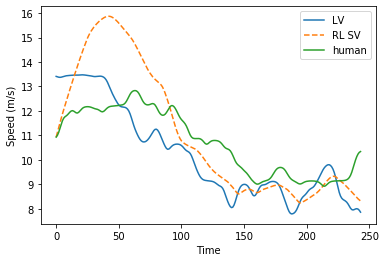

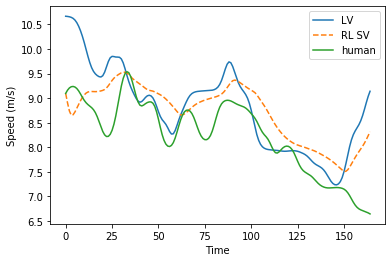

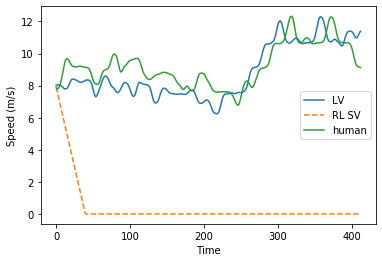

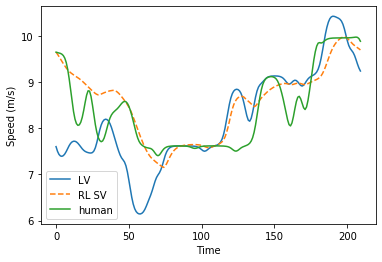

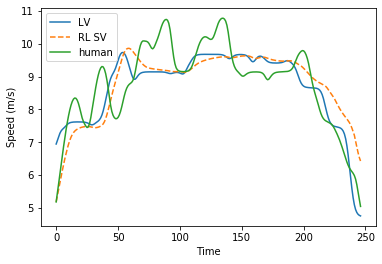

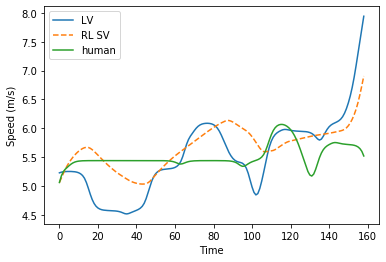

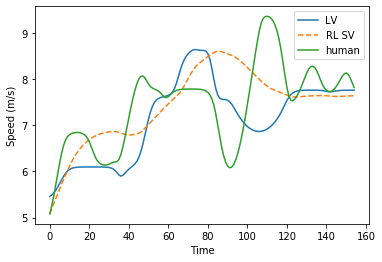

In [12]:
# plot some car-following trjectories
for i in range(20):
    data = sim_data[i]
    real_data = test[i,0]
    
    plt.figure()
    plt.plot(data[:,0], label = 'LV')
    plt.plot(data[:,1], '--', label = 'RL SV')
    plt.plot(real_data[:,1], label = 'human')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Speed (m/s)')

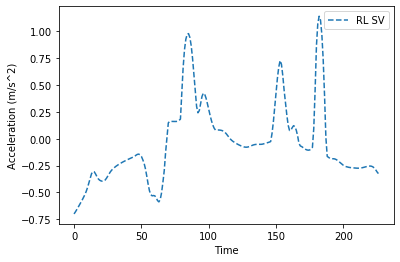

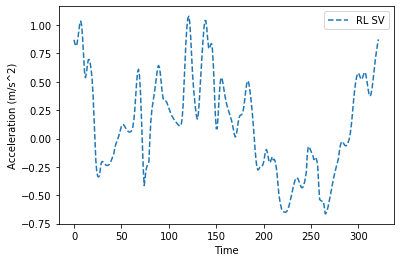

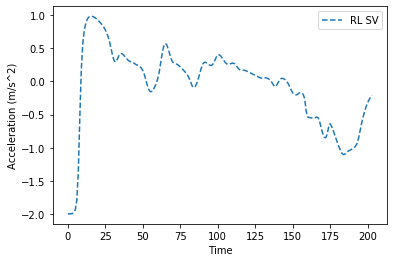

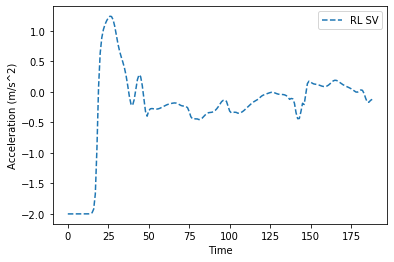

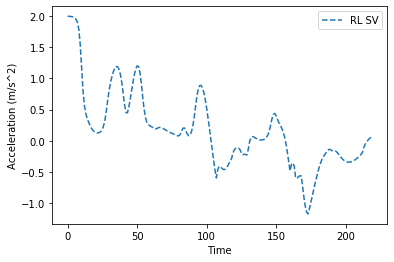

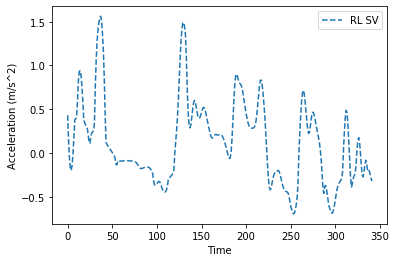

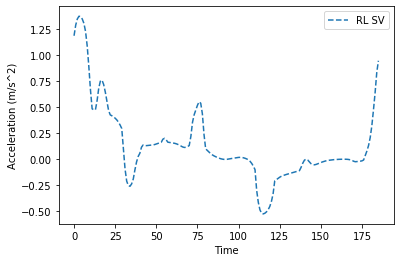

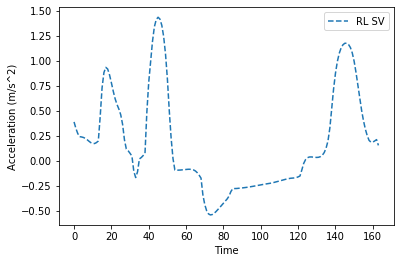

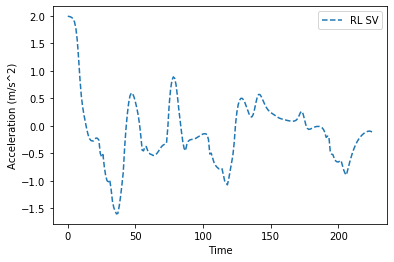

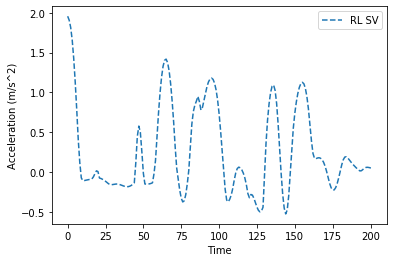

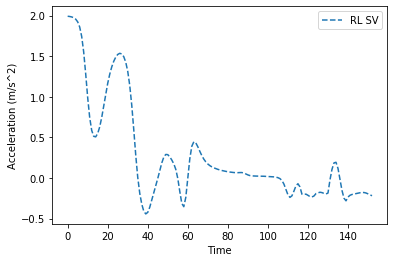

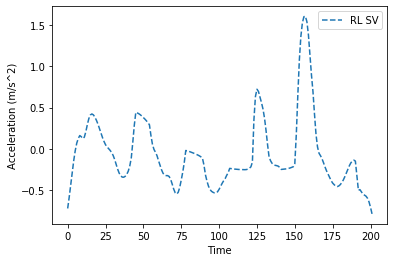

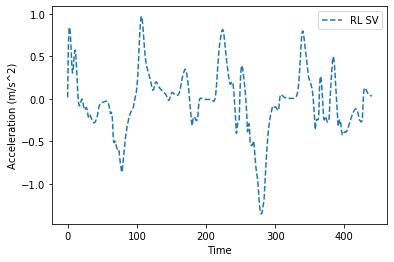

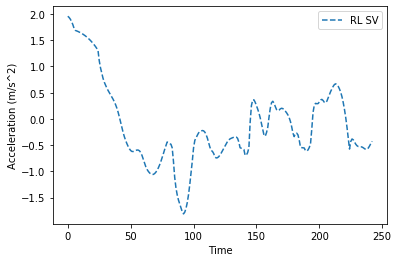

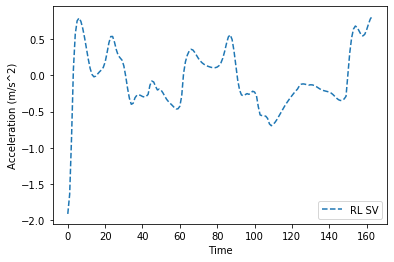

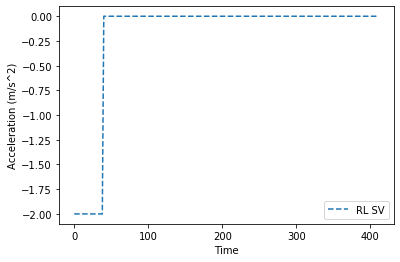

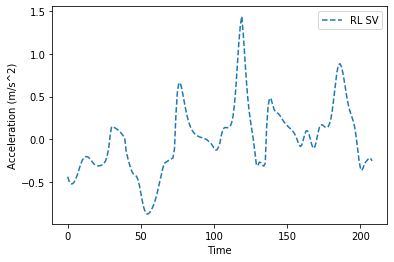

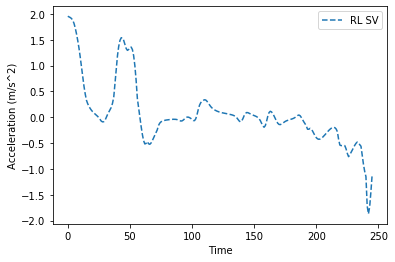

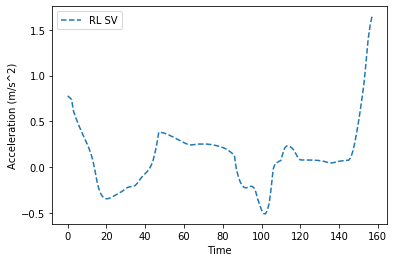

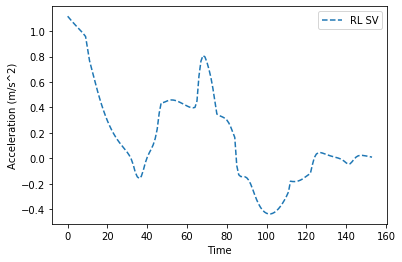

In [13]:
# plot some car-following trjectories
for i in range(20):
    data = sim_data[i]
    real_data = test[i,0]
    
    plt.figure()
    
    plt.plot(np.diff(data[:,1])/0.1, '--', label = 'RL SV')
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Acceleration (m/s^2)')

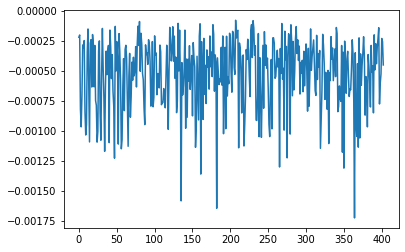

In [14]:
plt.plot(score_comfort)

In [15]:
np.mean(reward_data[:,2])

-0.011819608743143752

In [16]:
env.TTC_threshold

10.1